In [2]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import warnings
import matplotlib.pyplot as plot
import matplotlib as mpl
warnings.simplefilter(action='ignore',category=FutureWarning)

In [3]:
def bsm_call_value(S0, K,T,r,sigma):
    '''
    S0: initial stock/index level
    K: strike price
    T: maturity date
    r: constant risk-free short rate
    sigma: volatility factor in diffusion term
    value: present value of the European call option
    '''
    from math import log, sqrt, exp
    from scipy import stats
    
    S0 = float(S0)
    d1 = (log(S0/K) + (r+0.5*sigma **2)*T) / (sigma * sqrt(T))
    d2 = (log(S0/K) + (r-0.5*sigma **2)*T) / (sigma * sqrt(T))
    value = (S0* stats.norm.cdf(d1, 0.0,1.0)
            - K*exp(-r*T)* stats.norm.cdf(d2,0.0,1.0))
    return value 

In [4]:
# Vega
def bsm_vega(S0, K, T, r, sigma):
    from math import log, sqrt
    from scipy import stats
    
    S0 = float(S0)
    d1 = (log(S0/K) + (r+0.5*sigma**2)*T) / (sigma*sqrt(T))
    vega = S0 * stats.norm.cdf(d1, 0.0, 1.0) * sqrt(T)
    return vega

In [5]:
#implied volatility function
def bsm_call_imp_vol(S0, K, T, r, C0,sigma_est, it=100):
    '''
    sigma_est: estimate of impl. volatility
    it: number of iterations
    '''
    for i in range(it):
        sigma_est = ((bsm_call_value(S0, K,T,r,sigma_est) - C0)
                    /bsm_vega(S0, K,T,r,sigma_est))
    return sigma_est

In [6]:
import urllib.request
es_url = 'http://www.stoxx.com/download/historical_values/hbrbcpe.txt'
vs_url = 'http://www.stoxx.com/download/historical_values/h_vstoxx.txt'
urllib.request.urlretrieve(es_url,'D:/Python/exercise/es.txt')
urllib.request.urlretrieve(vs_url, 'D:/Python/exercise/vs.txt')

ContentTooShortError: <urlopen error retrieval incomplete: got only 229368 out of 688500 bytes>

Monte Carlo Simulation

In [7]:
#Monte Carlo valuation of European call option with pure python
from time import time
from math import exp, sqrt, log
from random import gauss, seed
seed(20000)
t0=time()

In [8]:
#Parameters
S0 = 100
K=105
T=1.0
r=0.05
sigma=0.2
M=50
dt=T/M
I=250000


In [9]:
# Simulating I paths with M time steps
S=[]
for i in range(I):
    path=[]
    for t in range(M+1):
        if t==0:
            path.append(S0)
        else:
            z=gauss(0.0,1.0)
            St=path[t-1]*exp((r-0.5*sigma**2)*dt
                             +sigma*sqrt(dt)*z)
            path.append(St)
    S.append(path)

In [10]:
#Calculating the Monte Carlo estimator
C0=exp(-r*T)*sum([max(path[-1] - K,0) for path in S])/I

In [11]:
#Results output
tpy = time() - t0
print("Euro option value %7.3f"%C0)
print("Duration in Seconds %7.3f"%tpy)

Euro option value   7.999
Duration in Seconds  39.552


In [12]:
sum_val = 0.0
for path in S:
    sum_val += max(path[-1] - K,0)
C0=exp(-r*T)*sum_val / I
round(C0,3)

7.999

Monte Carlo -Numpy向量化

In [13]:
#Monte Carlo valuation of European call options with Numpy
from time import time
import math
np.random.seed(20000)
t0=time()

In [14]:
#Parameters
S0=100.;K=105.;T=1.0;r=0.05;sigma=0.2
M=50; dt=T/M; I=250000

#Simulation I paths with M time steps
S=np.zeros((M+1,I))
S[0] = S0
for t in range(1,M+1):
    z=np.random.standard_normal(I)
    S[t]=S[t-1] * np.exp((r - 0.5*sigma**2)*dt
                        +sigma*math.sqrt(dt)*z)
    
#Calculating the Monte Carlo estimator
C0=math.exp(-r*T) *np.sum(np.maximum(S[-1] - K,0))/I

#results output 
tnp1= time() - t0
print('Euro option value %7.3f' %C0)
print('Duration in seconds %7.3f' %tnp1)

Euro option value   8.037
Duration in seconds   2.124


Monte Carlo -利用对数欧拉方法实现全向量化

In [15]:
#Monte Carlo valuation of European call options with Numpy log version
from numpy import *

random.seed(20000)
t0=time()

In [16]:
#Parameters 
S0=100.;K=105.;T=1.0;r=0.05;sigma=0.2
M=50; dt=T/M; I=250000

In [17]:
#Simulating I paths with M time steps
S = S0*exp(cumsum((r-0.5*sigma**2)*dt
                 +sigma * math.sqrt(dt)
                 *random.standard_normal((M+1, I)),axis=0))
#sum instead of cumsum would also do
S[0]=S0
C0=math.exp(-r * T)*sum(maximum(S[-1] - K,0))/I

In [18]:
#results output 
tnp2 = time()-t0
print('Euro option value %7.3f'%C0)
print('Duration in seconds %7.3f'%tnp2)

Euro option value   8.166
Duration in seconds   1.535


图形化分析

Text(0, 0.5, 'index level')

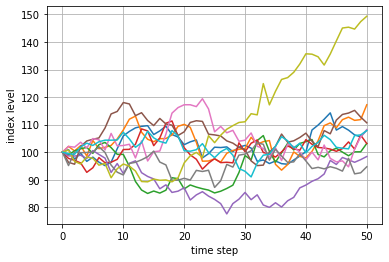

In [19]:
import matplotlib.pyplot as plt
plt.plot(S[:,:10])
plt.grid(True)
plt.xlabel('time step')
plt.ylabel('index level')

Text(0, 0.5, 'frequency')

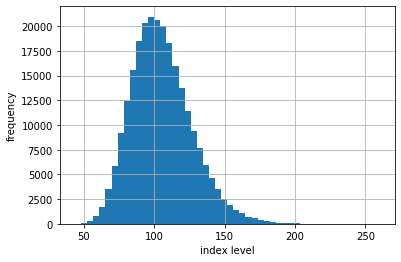

In [20]:
plt.hist(S[-1],bins=50)
plt.grid(True)
plt.xlabel('index level')
plt.ylabel('frequency')

(0, 50000)

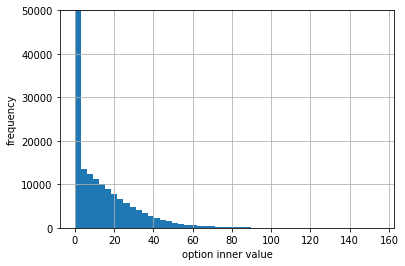

In [21]:
plt.hist(np.maximum(S[-1] - K,0),bins=50)
plt.grid(True)
plt.xlabel('option inner value')
plt.ylabel('frequency')
plt.ylim(0,50000)

技术分析

In [22]:
sp500=web.DataReader('^GSPC',data_source='yahoo',start='1/1/2010',end='2/14/2020')
sp500.info()
sp500.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2548 entries, 2009-12-31 to 2020-02-14
Data columns (total 6 columns):
High         2548 non-null float64
Low          2548 non-null float64
Open         2548 non-null float64
Close        2548 non-null float64
Volume       2548 non-null int64
Adj Close    2548 non-null float64
dtypes: float64(5), int64(1)
memory usage: 139.3 KB


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-31,1127.640015,1114.810059,1126.599976,1115.099976,2076990000,1115.099976
2010-01-04,1133.869995,1116.560059,1116.560059,1132.989990,3991400000,1132.989990
2010-01-05,1136.630005,1129.660034,1132.660034,1136.520020,2491020000,1136.520020
2010-01-06,1139.189941,1133.949951,1135.709961,1137.140015,4972660000,1137.140015
2010-01-07,1142.459961,1131.319946,1136.270020,1141.689941,5270680000,1141.689941


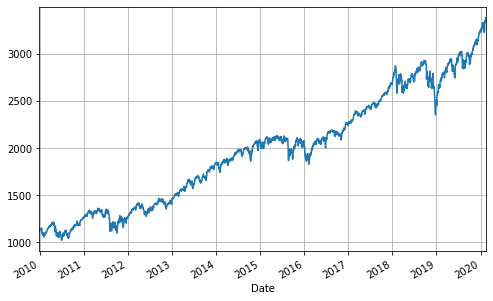

In [23]:
sp500['Close'].plot(grid=True,figsize=(8,5))

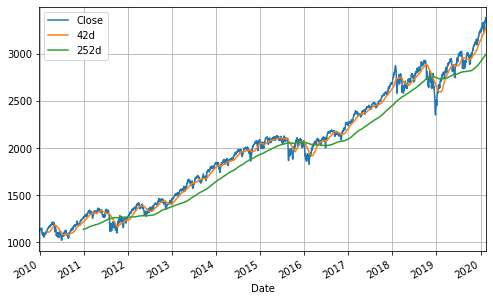

In [24]:
sp500['42d']=np.round(sp500['Close'].rolling(window=42).mean())
sp500['252d']=np.round(sp500['Close'].rolling(window=252).mean())
sp500[['Close','42d','252d']].plot(grid=True,figsize=(8,5))

In [25]:
sp500['42-252'] = sp500['42d'] - sp500['252d']
sp500['42-252'].tail()

Date
2020-02-10    272.0
2020-02-11    275.0
2020-02-12    278.0
2020-02-13    281.0
2020-02-14    283.0
Name: 42-252, dtype: float64

In [26]:
SD=50
sp500['Regime'] = np.where(sp500['42-252'] > SD, 1,0)
sp500['Regime'] = np.where(sp500['42-252'] < SD, -1,sp500['Regime'])
sp500['Regime'].value_counts()

 1    1770
-1     517
 0     261
Name: Regime, dtype: int64

(-1.1, 1.1)

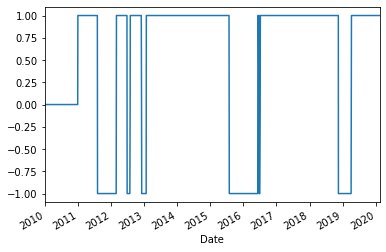

In [27]:
sp500['Regime'].plot(lw=1.5)
plt.ylim([-1.1,1.1])

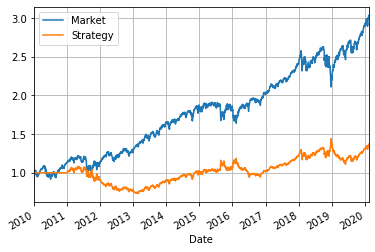

In [28]:
import matplotlib.pyplot as plot
sp500['Market'] = np.log(sp500['Close'] / sp500['Close'].shift(1))
sp500['Strategy'] = sp500['Regime'].shift(1)*sp500['Market']
sp500[['Market','Strategy']].cumsum().apply(np.exp).plot(grid=True)